# Lab 7: Optical Flow Tracking

***ในแล็บนี้ เราจะศึกษาการใช้ Optical Flow ในการ Track หรือติดตามวัตถุตัวอย่าง ซึ่งก็คือรถยนต์ ในภาพเคลื่อนไหวหรือวิดีโอ***

Optical Flow แสดงการเคลื่อนที่ของรูปภาพในเฟรมที่ต่อกัน วิธีโดยมากจะอิงการเคลื่อนที่จากค่าแสงสีของ Pixel และอธิบายในรูปของกลุ่มเวกเตอร์ 2D ที่บ่งบอกว่าจุด Pixel ต่าง ๆ นี้เคลื่อนที่ไปอยู่ตำแหน่งใดในเฟรมถัดไป เทคนิคนี้มีข้อสมมติหลัก 2 ข้อ คือ 1) ค่าแสงสีของ Pixel ของสิ่งเดิมหรือสิ่งเดียวกัน ไม่เปลี่ยนระหว่างเฟรม  และ 2) Pixel ในบริเวณเดียวกัน มีการเคลื่อนที่ที่คล้ายกัน

ในแล็บนี้จะใช้วิธี Gunnar Farneback's algorithm [2, 3] ในการคำนวณ Optical Flow ซึ่งจะได้ผลลัพธ์เป็น Dense Optical Flow หมายความว่าทุก Pixel ในภาพจะมีเวกเตอร์ระบุทิศทางที่ Pixel นั้นเคลื่อนที่ไปในเฟรมถัดไป ต่างจาก Sparse Optical Flow ที่จะระบุเวกเตอร์การกระจัดแค่สำหรับ Pixel บางกลุ่มที่มีลักษณะพิเศษเท่านั้น


**References**
1. https://docs.opencv.org/4.x/d4/dee/tutorial_optical_flow.html
2. Farneback, G. “Two-Frame Motion Estimation Based on Polynomial Expansion.” In Proceedings of the 13th Scandinavian Conference on Image Analysis, 363 - 370. Halmstad, Sweden: SCIA, 2003.
3. https://www.mathworks.com/help/vision/ref/opticalflowfarneback.html

## 1. การเตรียมข้อมูล

โหลดวิดีโอตัวอย่างของรถยนต์ที่วิ่งอยู่บนถนนจาก https://github.com/savnani5/Optical-Flow-Motion

In [ ]:
!wget -O "cars_on_highway.mp4" https://drive.google.com/uc?id=1TEfEyGDJvn8NSa7xUS5THI9HIkpTINCa&export=download

--2023-05-24 09:53:30--  https://drive.google.com/u/1/uc?id=1TEfEyGDJvn8NSa7xUS5THI9HIkpTINCa
Resolving drive.google.com (drive.google.com)... 142.251.2.138, 142.251.2.101, 142.251.2.113, ...
Connecting to drive.google.com (drive.google.com)|142.251.2.138|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1TEfEyGDJvn8NSa7xUS5THI9HIkpTINCa [following]
--2023-05-24 09:53:30--  https://drive.google.com/uc?id=1TEfEyGDJvn8NSa7xUS5THI9HIkpTINCa
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-6o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cpoath4q37eu3chu1bfsr58v85h01hah/1684921950000/11797005964751114850/*/1TEfEyGDJvn8NSa7xUS5THI9HIkpTINCa?uuid=22bfb467-9aa8-4403-98cb-60f7265b8c4a [following]
--2023-05-24 09:53:31--  https://doc-00-6o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cpoath4q37eu3c

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

เปิดไฟล์วิดีโอด้วยฟังก์ชัน `VideoCapture`

In [ ]:
cap = cv2.VideoCapture("cars_on_highway.mp4")
ret, frame1 = cap.read()
width = frame1.shape[1]
height = frame1.shape[0]

สร้างภาพสำหรับเก็บ Annotation ตำแหน่งการเคลื่อนที่ของรถยนต์ในแต่ละเฟรม และเก็บ Optical Flow ในแต่ละเฟรม

In [ ]:
mask = np.zeros_like(frame1)

hsv = np.zeros_like(frame1)
hsv[...,1] = 255

เปิดไฟล์สำหรับบันทึกผลลัพธ์การติดตามตำแหน่งรถยนต์ในภาพ และ Optical Flow ที่คำนวณได้ในแต่ละเฟรม และสร้างฟังก์ชันสำหรับวาด Optical Flow ซ้อนลงบนภาพ

In [ ]:
out = cv2.VideoWriter('cars_track.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 20, (width,height))
out_opf = cv2.VideoWriter('cars_flow.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 20, (width,height))

In [ ]:
def draw_flow(img, flow, step=25):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = img
    cv2.polylines(vis, lines, 0, (0, 255, 0), 2)
    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 2, (0, 0, 255), -1)
    return vis

ป้อนตำแหน่งของวัตถุหรือรถที่ต้องการติดตามในเฟรมเริ่มต้น และกำหนดสีสำหรับ Annotation

In [ ]:
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)

p0 = np.array([[[930,700]],
               [[760,500]],
               [[700,380]],
               [[590,340]],
               [[1020,380]],
               [[1360,560]],
               [[330,320]]], dtype='float32')
color = np.random.randint(0, 255, (7, 3))

## 2. การคำนวณ Optical Flow และติดตามวัตถุ

หลังจากนั้นในแต่ละเฟรม ดำเนินการดังนี้
1. คำนวณ Optical Flow ของเฟรมนั้น
2. คำนวณตำแหน่งของวัตถุในเฟรมถัดไป
3. บันทึกผลลัพธ์ และอัพเดทเฟรมและตำแหน่งของวัตถุ

In [ ]:
while(1):
    ret, frame2 = cap.read()

    if ret == True:
        width = frame1.shape[1]
        height = frame1.shape[0]

        # calculate optical flow
        next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        # calculate new objects' positions
        p1 = p0 + flow[np.int16(np.round(p0[:,:,1])), np.int16(np.round(p0[:,:,0])),:]
        p1[:,:,0] = np.clip(p1[:,:,0], 0, width-1)
        p1[:,:,1] = np.clip(p1[:,:,1], 0, height-1)

        # draw the tracks
        img = frame2
        for i, (new, old) in enumerate(zip(p1, p0)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 5)
            img = cv2.circle(img, (int(a), int(b)), 10, color[i].tolist(), -1)
        img = cv2.add(img, mask)

        # draw the optical flow
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
        bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        frame3 = draw_flow(frame2, flow)

        # save to vdo file
        out.write(img)
        out_opf.write(frame3)

        # update frame and objects' positions
        prvs = next
        p0 = p1
    else:
        break
cap.release()
out.release()
out_opf.release()
print('done')

done


แสดงภาพผลลัพธ์การติดตามรถ แต่ละเส้นแทนการเคลื่อนของ 1 วัตถุ

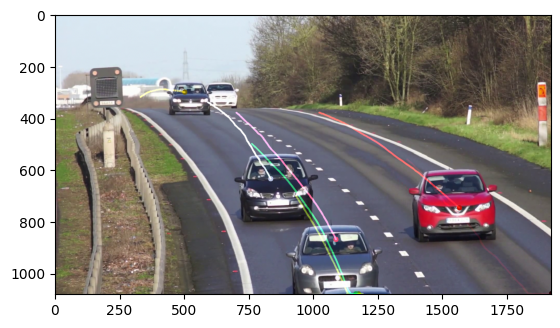

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255)

## 3. แสดงผลลัพธ์

เพื่อให้สามารถแสดงบน Colab ได้ ใช้ `ffmpeg` บีบอัดวิดีโอ แล้วแสดงผลด้วย HTML

In [ ]:
from IPython.display import HTML
from base64 import b64encode

In [ ]:
!ffmpeg -y -i cars_track.mp4  -vcodec libx264  cars_track_compress.mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [ ]:
mp4 = open('cars_track_compress.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!ffmpeg -y -i cars_flow.mp4  -vcodec libx264  cars_flow_compress.mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [ ]:
mp4 = open('cars_flow_compress.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1000 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

----